In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Goal of this model is to identify if it is a Scarlet Kingsnake (non-venemous) or if it is a Coral Snake(venomous).

I will use duckduckgo search engine images to accomplish this task.

In [2]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ypy-websocket 0.8.2 requires aiofiles<23,>=22.1.0, but you have aiofiles 23.2.1 which is incompatible.


## Download Images of Scarlet Kingsnakes

In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images( term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [4]:
urls = search_images('Scarlet Kingsnake photos', max_images=1)
urls[0]

Searching for 'Scarlet Kingsnake photos'


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


'https://i.pinimg.com/originals/c6/f2/b2/c6f2b285a795d5dce084be5a198d79d1.jpg'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


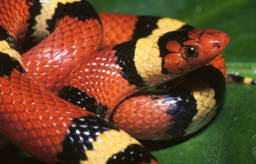

In [5]:
from fastdownload import download_url
dest = 'non-venomous.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

## Download Images Coral snakes


Searching for 'Coral snake photos'


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


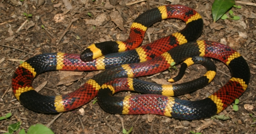

In [6]:
download_url(search_images('Coral snake photos', max_images=1)[0], 'venomous.jpg', show_progress=False)
Image.open('venomous.jpg').to_thumb(256,256)

In [7]:
searches = 'Scarlet Kingsnake','Coral snake'
path = Path('venmous_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents =True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)
    
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'Scarlet Kingsnake photo'
Searching for 'Coral snake photo'


## Training our model


In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

7

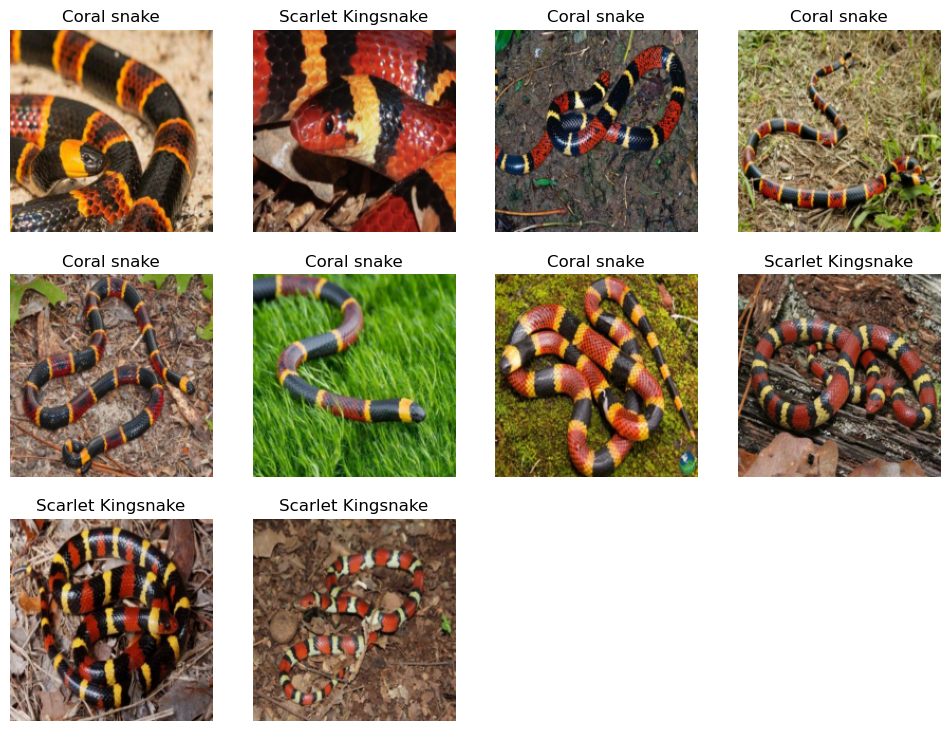

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=10)

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.880017,3.012821,0.600000,00:05


epoch,train_loss,valid_loss,error_rate,time
0,1.515396,2.115505,0.500000,00:01
1,1.214174,0.997059,0.200000,00:00
2,0.929189,0.625052,0.200000,00:00
3,0.734423,0.529736,0.200000,00:00


## Using this model to idenity an actual image of a venomous snake:


In [11]:
is_venomous,_,probs = learn.predict(PILImage.create('venomous.jpg'))
if is_venomous:
    print("This is a Coral snake: Poisonous!.")
    print(f"Probability it's a venomous snake is:{probs[0]:.4f}")
else:
    print("This is not a Coral Snake, Probably a Scarlet Kingsnake: Not - Poisonous.")
    print(f"Probability it's non-venomous snake is:{1 - probs[0]:.4f}")
    





This is a Coral snake: Poisonous!.
Probability it's a venomous snake is:0.9904
